In [7]:
import warnings

# Suppress specific warnings by category
warnings.filterwarnings("ignore")

# speaker_diarization_transcription.py

import os
from dotenv import load_dotenv
import torch
from pyannote.audio import Pipeline
from pydub import AudioSegment
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from collections import defaultdict

class SpeakerDiarizationTranscription:
    def __init__(self):
        # Load environment variables from .env file
        load_dotenv()

        # Access the Hugging Face token
        self.huggingface_token = os.getenv("HUGGINGFACE_TOKEN")

        # Check if the token was loaded correctly
        if self.huggingface_token:
            print("Hugging Face token loaded successfully.")
        else:
            raise ValueError("Failed to load Hugging Face token. Check your .env file.")

        # Initialize the models
        self.pipeline = self.load_pyannote_model()
        self.pipe = self.load_whisper_model()

    def load_pyannote_model(self):
        # Initialize the pyannote pipeline
        pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization@2.1", use_auth_token=self.huggingface_token)

        # Check if CUDA is available and move the pipeline to GPU if it is
        if torch.cuda.is_available():
            pipeline.to(torch.device("cuda"))
            print("Pyannote pipeline moved to GPU.")
        else:
            print("CUDA is not available. The pyannote pipeline will run on the CPU.")

        return pipeline

    def convert_to_wav(self, audio_file):
        # Check if the file is mp3 and convert to wav if necessary
        if audio_file.lower().endswith('.mp3'):
            audio = AudioSegment.from_file(audio_file)
            wav_file = audio_file.rsplit('.', 1)[0] + '.wav'
            audio.export(wav_file, format="wav")
            return wav_file
        else:
            return audio_file

    def perform_diarization(self, wav_file, num_speakers=2):
        # Initialize an empty list to store the diarization entries
        diarization_list = []

        # Apply the pipeline to the wav file
        diarization = self.pipeline(wav_file, num_speakers=num_speakers)

        # Iterate over the diarization results and build the list of dictionaries
        for turn, _, speaker in diarization.itertracks(yield_label=True):
            # Create a dictionary for each diarization segment
            diarization_entry = {
                'start': turn.start,
                'stop': turn.end,
                'speaker': speaker
            }
            # Add the dictionary to the list
            diarization_list.append(diarization_entry)

        return diarization_list

    def load_whisper_model(self):
        # Set device and data types
        device = "cuda" if torch.cuda.is_available() else "cpu"
        torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

        # Specify the model ID
        model_id = "openai/whisper-large-v3-turbo"

        # Load the model
        model = AutoModelForSpeechSeq2Seq.from_pretrained(
            model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True
        )
        model.to(device)

        # Load the processor
        processor = AutoProcessor.from_pretrained(model_id)

        # Create the pipeline
        pipe = pipeline(
            "automatic-speech-recognition",
            model=model,
            tokenizer=processor.tokenizer,
            feature_extractor=processor.feature_extractor,
            torch_dtype=torch_dtype,
            device=device,
        )

        print("Whisper model loaded successfully.")

        return pipe

    def transcribe_audio(self, wav_file):
        # Transcribe an audio file directly in the pipeline call
        result = self.pipe(wav_file, return_timestamps=True)
        transcription = result["chunks"]  # Extract transcription chunks
        return transcription

    def assign_speakers_to_transcription(self, diarization, transcription):
        """Assign speaker labels to transcription chunks based on diarization."""
        def get_overlap(a_start, a_end, b_start, b_end):
            """Calculate the overlap duration between two time intervals."""
            overlap_start = max(a_start, b_start)
            overlap_end = min(a_end, b_end)
            return max(0.0, overlap_end - overlap_start)

        # For each transcription chunk
        for chunk in transcription:
            t_start, t_end = chunk['timestamp']
            # Keep track of overlapping durations per speaker
            overlaps = defaultdict(float)
            for diar in diarization:
                d_start = diar['start']
                d_end = diar['stop']
                speaker = diar['speaker']
                overlap = get_overlap(t_start, t_end, d_start, d_end)
                if overlap > 0:
                    overlaps[speaker] += overlap
            # Determine the speaker with the maximum overlap
            if overlaps:
                assigned_speaker = max(overlaps.items(), key=lambda x: x[1])[0]
            else:
                assigned_speaker = 'Unknown'
            # Assign the speaker to the chunk
            chunk['speaker'] = assigned_speaker
        return transcription

    def get_diarization_and_transcription(self, audio_file, num_speakers):
        # Convert to wav if necessary
        wav_file = self.convert_to_wav(audio_file)

        # Perform diarization
        print("Starting speaker diarization...")
        diarization_list = self.perform_diarization(wav_file, num_speakers)
        print("Speaker diarization completed.")

        # Transcribe audio
        print("Starting transcription...")
        transcription = self.transcribe_audio(wav_file)
        print("Transcription completed.")

        # Clean up the temporary wav file if it was created
        if wav_file != audio_file:
            os.remove(wav_file)

        return diarization_list, transcription

    def process_audio(self, audio_file, num_speakers):
        # Convert to wav if necessary
        wav_file = self.convert_to_wav(audio_file)

        # Perform diarization
        print("Starting speaker diarization...")
        diarization_list = self.perform_diarization(wav_file, num_speakers)
        print("Speaker diarization completed.")

        # Transcribe audio
        print("Starting transcription...")
        transcription = self.transcribe_audio(wav_file)
        print("Transcription completed.")

        # Assign speakers to transcription
        print("Assigning speakers to transcription...")
        combined_result = self.assign_speakers_to_transcription(diarization_list, transcription)
        print("Speaker assignment completed.")

        # Clean up the temporary wav file if it was created
        if wav_file != audio_file:
            os.remove(wav_file)

        return combined_result

def main():
    # Path to your audio file
    audio_file = "/mnt/c/Users/luisg/Desktop/STAR/STAR/audio_samples/conversation_sample_2.mp3"  # Replace with your audio file path

    # Define number of speakers
    num_speakers = 2

    # Create an instance of the class
    sdt = SpeakerDiarizationTranscription()

    # Process the audio file
    combined_result = sdt.process_audio(audio_file, num_speakers)

    # Print the results
    for chunk in combined_result:
        print(f"Speaker {chunk['speaker']}: {chunk['text']}")

In [9]:
main()

Hugging Face token loaded successfully.


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../../../home/luis/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cu124. Bad things might happen unless you revert torch to 1.x.


INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding

Pyannote pipeline moved to GPU.
Whisper model loaded successfully.
Starting speaker diarization...
Speaker diarization completed.
Starting transcription...
Transcription completed.
Assigning speakers to transcription...
Speaker assignment completed.
Speaker SPEAKER_01:  So, what's new, Mark?
Speaker SPEAKER_01:  How is your new job going?
Speaker SPEAKER_00:  To be honest, I can't complain.
Speaker SPEAKER_00:  I really love the company that I am working for.
Speaker SPEAKER_00:  My co-workers are all really friendly and helpful.
Speaker Unknown:  They really help me feel welcome.
Speaker Unknown:  It's a really energetic and fun atmosphere.
Speaker Unknown:  My boss is hilarious.
Speaker SPEAKER_01:  And he's really flexible.
Speaker SPEAKER_01:  Really?
Speaker SPEAKER_01:  How so?
Speaker SPEAKER_00:  He allows me to come in when I want and make my own hours.
Speaker SPEAKER_00:  I can also leave early if I start early.
Speaker Unknown:  There is no real dress code either.
Speaker U

In [8]:
# Path to your audio file
audio_file = "/mnt/c/Users/luisg/Desktop/STAR/STAR/audio_samples/conversation_sample_2.mp3"  # Replace with your audio file path

# Define number of speakers
num_speakers = 2


# Create an instance of the class
sdt = SpeakerDiarizationTranscription()

# Call the get_diarization_and_transcription function
diarization_list, transcription = sdt.get_diarization_and_transcription(audio_file, num_speakers)

# Print diarization information
print("Diarization List:")
for entry in diarization_list:
    print(entry)

# Print transcription
print("Transcription:")
for chunk in transcription:
    print(f"{chunk['timestamp']}: {chunk['text']}")


Hugging Face token loaded successfully.


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../../../home/luis/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cu124. Bad things might happen unless you revert torch to 1.x.


INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding

Pyannote pipeline moved to GPU.
Whisper model loaded successfully.
Starting speaker diarization...
Speaker diarization completed.
Starting transcription...
Transcription completed.
Diarization List:
{'start': 12.36659375, 'stop': 16.973468750000002, 'speaker': 'SPEAKER_01'}
{'start': 16.973468750000002, 'stop': 24.90471875, 'speaker': 'SPEAKER_00'}
{'start': 26.153468750000002, 'stop': 33.173468750000005, 'speaker': 'SPEAKER_00'}
{'start': 34.118468750000005, 'stop': 37.392218750000005, 'speaker': 'SPEAKER_00'}
{'start': 38.32034375, 'stop': 40.51409375, 'speaker': 'SPEAKER_00'}
{'start': 41.17221875, 'stop': 44.445968750000006, 'speaker': 'SPEAKER_00'}
{'start': 45.67784375, 'stop': 46.60596875, 'speaker': 'SPEAKER_00'}
{'start': 47.70284375, 'stop': 53.06909375, 'speaker': 'SPEAKER_00'}
{'start': 53.929718750000006, 'stop': 57.16971875, 'speaker': 'SPEAKER_00'}
{'start': 57.861593750000004, 'stop': 69.21846875, 'speaker': 'SPEAKER_00'}
{'start': 68.57721875, 'stop': 69.20159375, 'spe

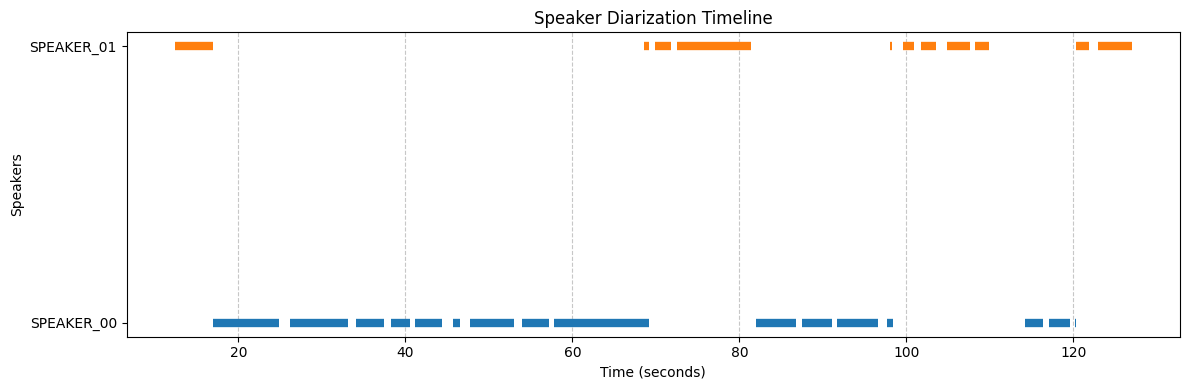

In [10]:
import matplotlib.pyplot as plt

# Extract unique speakers and assign y-positions
speakers = sorted(set(entry['speaker'] for entry in diarization_list))
speaker_to_y = {speaker: i for i, speaker in enumerate(speakers)}

# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))

for entry in diarization_list:
    start = entry['start']
    stop = entry['stop']
    speaker = entry['speaker']
    y = speaker_to_y[speaker]
    ax.hlines(y, start, stop, colors=f'C{y}', linewidth=6)

# Customize the plot
ax.set_yticks(list(speaker_to_y.values()))
ax.set_yticklabels(list(speaker_to_y.keys()))
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Speakers')
ax.set_title('Speaker Diarization Timeline')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [11]:
# Adjust the timestamps to be continuous
adjusted_transcription = []
cumulative_offset = 0.0

for i, chunk in enumerate(transcription):
    start, end = chunk['timestamp']
    duration = end - start
    
    # Check if the current start time is less than the previous end time
    if i > 0 and start < transcription[i - 1]['timestamp'][1]:
        # Add the previous segment's end time to cumulative_offset
        cumulative_offset += transcription[i - 1]['timestamp'][1]
    
    adjusted_start = cumulative_offset + start
    adjusted_end = cumulative_offset + end
    
    adjusted_transcription.append({
        'start': adjusted_start,
        'stop': adjusted_end,
        'text': chunk['text']
    })

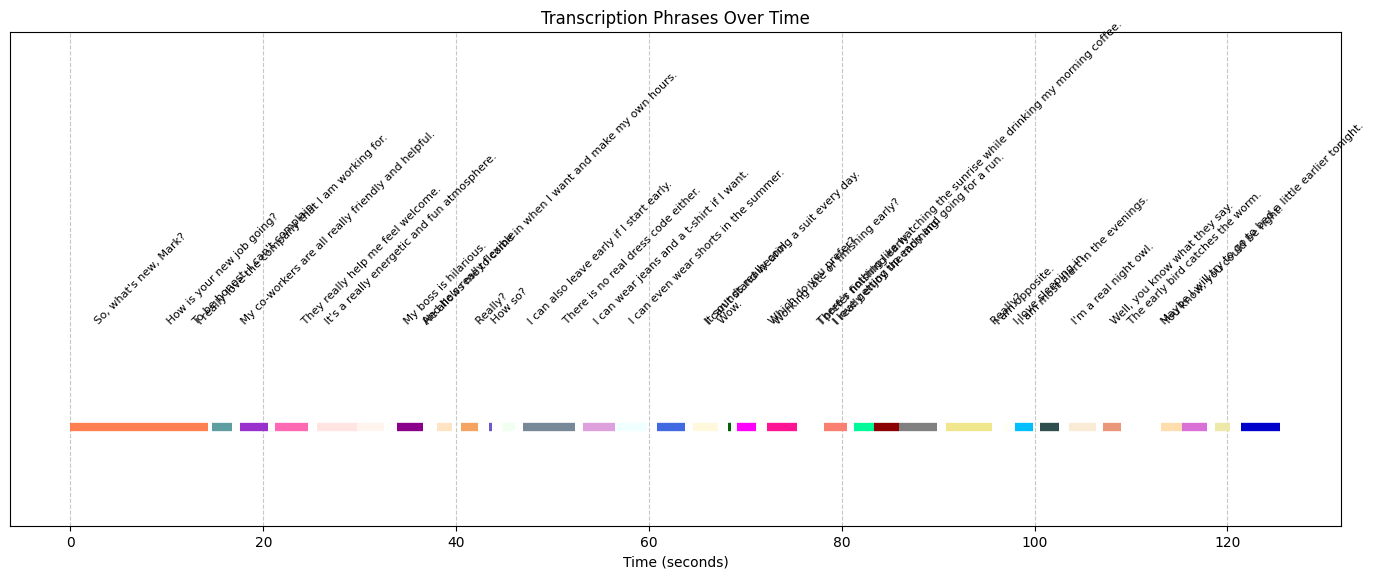

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

# Generate a list of unique colors
all_colors = list(mcolors.CSS4_COLORS.keys())
random.shuffle(all_colors)  # Shuffle to get a random assortment of colors

# Ensure we have enough colors
if len(all_colors) < len(adjusted_transcription):
    # Repeat colors if not enough (unlikely with CSS4_COLORS)
    all_colors = (all_colors * (len(adjusted_transcription) // len(all_colors) + 1))[:len(adjusted_transcription)]

fig, ax = plt.subplots(figsize=(14, 6))

for i, entry in enumerate(adjusted_transcription):
    start = entry['start']
    stop = entry['stop']
    text = entry['text']
    color = all_colors[i]
    ax.hlines(1, start, stop, colors=color, linewidth=6)
    # Optionally, add text labels
    ax.text((start + stop)/2, 1.05, text, rotation=45, ha='center', va='bottom', fontsize=8)

# Customize the plot
ax.set_xlabel('Time (seconds)')
ax.set_yticks([])
ax.set_ylim(0.95, 1.2)
ax.set_title('Transcription Phrases Over Time')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

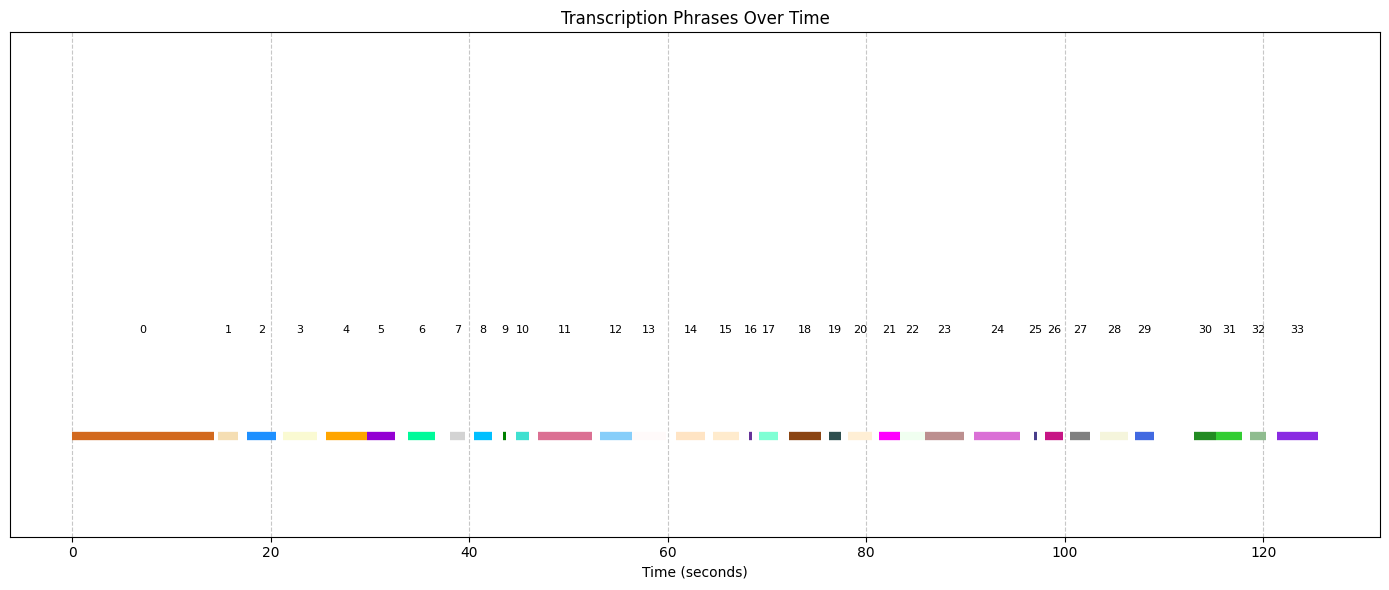

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

# Generate a list of unique colors
all_colors = list(mcolors.CSS4_COLORS.keys())
random.shuffle(all_colors)  # Shuffle to get a random assortment of colors

# Ensure we have enough colors
if len(all_colors) < len(adjusted_transcription):
    # Repeat colors if not enough (unlikely with CSS4_COLORS)
    all_colors = (all_colors * (len(adjusted_transcription) // len(all_colors) + 1))[:len(adjusted_transcription)]

fig, ax = plt.subplots(figsize=(14, 6))

for i, entry in enumerate(adjusted_transcription):
    start = entry['start']
    stop = entry['stop']
    text = i
    color = all_colors[i]
    ax.hlines(1, start, stop, colors=color, linewidth=6)
    # Optionally, add text labels
    ax.text((start + stop)/2, 1.05, text, rotation=0, ha='center', va='bottom', fontsize=8)

# Customize the plot
ax.set_xlabel('Time (seconds)')
ax.set_yticks([])
ax.set_ylim(0.95, 1.2)
ax.set_title('Transcription Phrases Over Time')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

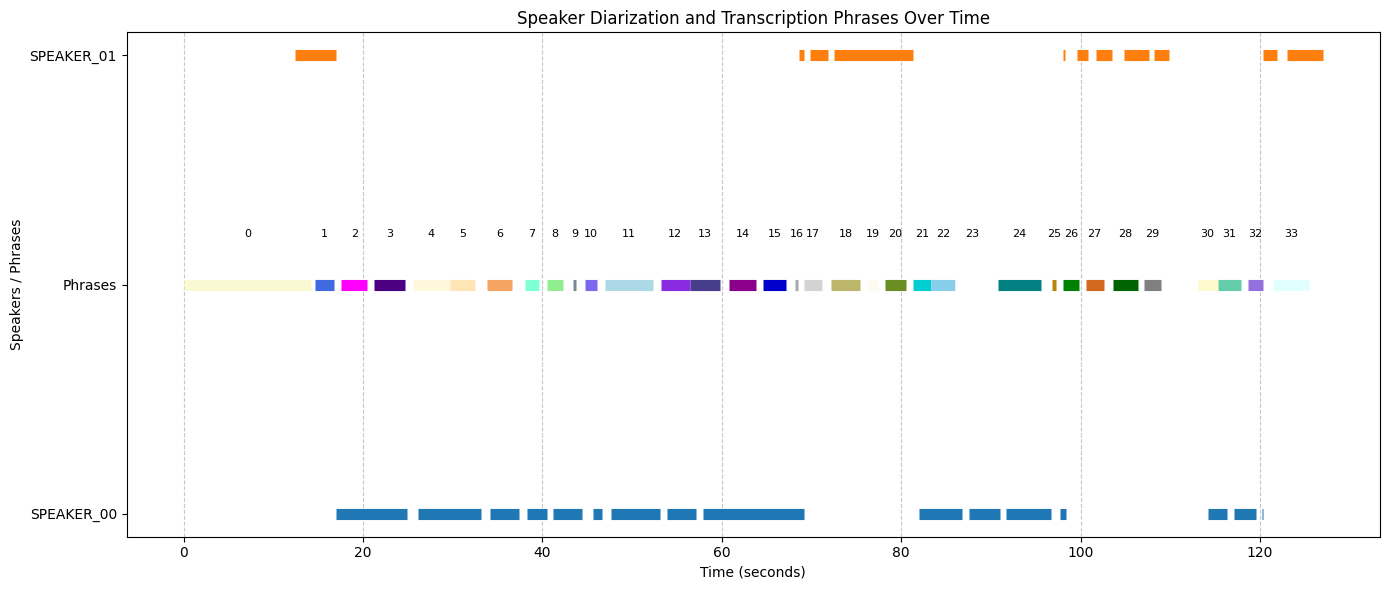

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

# Sample data - replace `diarization_list` and `adjusted_transcription` with your actual data
# Example structure for diarization_list
# diarization_list = [{'start': 5, 'stop': 10, 'speaker': 'SPEAKER_00'}, ...]

# Example structure for adjusted_transcription
# adjusted_transcription = [{'start': 5, 'stop': 10, 'text': 'phrase 1'}, ...]

# Extract unique speakers and assign y-positions closer together
speakers = sorted(set(entry['speaker'] for entry in diarization_list))
speaker_to_y = {speakers[0]: 0, speakers[1]: 1}  # Place SPEAKER_00 at y=0 and SPEAKER_01 at y=1

# Generate a list of unique colors for transcription phrases
all_colors = list(mcolors.CSS4_COLORS.keys())
random.shuffle(all_colors)  # Shuffle to get a random assortment of colors

# Ensure we have enough colors for transcription phrases
if len(all_colors) < len(adjusted_transcription):
    all_colors = (all_colors * (len(adjusted_transcription) // len(all_colors) + 1))[:len(adjusted_transcription)]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot speaker diarization timeline with thicker bars
for entry in diarization_list:
    start = entry['start']
    stop = entry['stop']
    speaker = entry['speaker']
    y = speaker_to_y[speaker]
    ax.hlines(y, start, stop, colors=f'C{y}', linewidth=8)  # Thicker lines for visibility

# Plot transcription phrases even closer to the speakers, at y=0.5
for i, entry in enumerate(adjusted_transcription):
    start = entry['start']
    stop = entry['stop']
    color = all_colors[i]
    ax.hlines(0.5, start, stop, colors=color, linewidth=8)  # Place phrases close between the speakers
    ax.text((start + stop) / 2, 0.6, str(i), ha='center', va='bottom', fontsize=8)

# Customize the plot
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['SPEAKER_00', 'Phrases', 'SPEAKER_01'])
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Speakers / Phrases')
ax.set_title('Speaker Diarization and Transcription Phrases Over Time')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## IMPROVE DIARIZATION OVERLAY BASED ON FINDINGS

In [ ]:
import warnings

# Suppress specific warnings by category
warnings.filterwarnings("ignore")

# speaker_diarization_transcription.py

import os
from dotenv import load_dotenv
import torch
from pyannote.audio import Pipeline
from pydub import AudioSegment
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from collections import defaultdict

class SpeakerDiarizationTranscription:
    def __init__(self):
        # Load environment variables from .env file
        load_dotenv()

        # Access the Hugging Face token
        self.huggingface_token = os.getenv("HUGGINGFACE_TOKEN")

        # Check if the token was loaded correctly
        if self.huggingface_token:
            print("Hugging Face token loaded successfully.")
        else:
            raise ValueError("Failed to load Hugging Face token. Check your .env file.")

        # Initialize the models
        self.pipeline = self.load_pyannote_model()
        self.pipe = self.load_whisper_model()

    def load_pyannote_model(self):
        # Initialize the pyannote pipeline
        pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization@2.1", use_auth_token=self.huggingface_token)

        # Check if CUDA is available and move the pipeline to GPU if it is
        if torch.cuda.is_available():
            pipeline.to(torch.device("cuda"))
            print("Pyannote pipeline moved to GPU.")
        else:
            print("CUDA is not available. The pyannote pipeline will run on the CPU.")

        return pipeline

    def convert_to_wav(self, audio_file):
        # Check if the file is mp3 and convert to wav if necessary
        if audio_file.lower().endswith('.mp3'):
            audio = AudioSegment.from_file(audio_file)
            wav_file = audio_file.rsplit('.', 1)[0] + '.wav'
            audio.export(wav_file, format="wav")
            return wav_file
        else:
            return audio_file

    def perform_diarization(self, wav_file, num_speakers=2):
        # Initialize an empty list to store the diarization entries
        diarization_list = []

        # Apply the pipeline to the wav file
        diarization = self.pipeline(wav_file, num_speakers=num_speakers)

        # Iterate over the diarization results and build the list of dictionaries
        for turn, _, speaker in diarization.itertracks(yield_label=True):
            # Create a dictionary for each diarization segment
            diarization_entry = {
                'start': turn.start,
                'stop': turn.end,
                'speaker': speaker
            }
            # Add the dictionary to the list
            diarization_list.append(diarization_entry)

        return diarization_list

    def load_whisper_model(self):
        # Set device and data types
        device = "cuda" if torch.cuda.is_available() else "cpu"
        torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

        # Specify the model ID
        model_id = "openai/whisper-large-v3-turbo"

        # Load the model
        model = AutoModelForSpeechSeq2Seq.from_pretrained(
            model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True
        )
        model.to(device)

        # Load the processor
        processor = AutoProcessor.from_pretrained(model_id)

        # Create the pipeline
        pipe = pipeline(
            "automatic-speech-recognition",
            model=model,
            tokenizer=processor.tokenizer,
            feature_extractor=processor.feature_extractor,
            torch_dtype=torch_dtype,
            device=device,
        )

        print("Whisper model loaded successfully.")

        return pipe

    def transcribe_audio(self, wav_file):
        # Transcribe an audio file directly in the pipeline call
        result = self.pipe(wav_file, return_timestamps=True)
        transcription = result["chunks"]  # Extract transcription chunks
        return transcription

    def assign_speakers_to_transcription(self, diarization, transcription):
        """Assign speaker labels to transcription chunks based on diarization."""

        def get_overlap(a_start, a_end, b_start, b_end):
            """Calculate the overlap duration between two time intervals."""
            overlap_start = max(a_start, b_start)
            overlap_end = min(a_end, b_end)
            return max(0.0, overlap_end - overlap_start)

        def merge_intervals(intervals):
            """Merge overlapping and consecutive intervals."""
            sorted_intervals = sorted(intervals, key=lambda x: x[0])
            merged = []
            for interval in sorted_intervals:
                if not merged:
                    merged.append(interval)
                else:
                    prev_start, prev_end = merged[-1]
                    curr_start, curr_end = interval
                    # Merge if intervals overlap or are consecutive
                    if curr_start <= prev_end + 1e-6:  # Adjust threshold as needed
                        merged[-1] = (prev_start, max(prev_end, curr_end))
                    else:
                        merged.append(interval)
            return merged

        # Ensure timestamps are in the same units
        # Adjust this part based on your actual data
        for diar in diarization:
            diar['start'] = float(diar['start'])
            diar['stop'] = float(diar['stop'])

        for chunk in transcription:
            t_start, t_end = chunk['timestamp']
            chunk['timestamp'] = (float(t_start), float(t_end))

        # Aggregate and merge diarization data per speaker
        speaker_intervals = defaultdict(list)
        for diar in diarization:
            d_start = diar['start']
            d_end = diar['stop']
            speaker = diar['speaker']
            speaker_intervals[speaker].append((d_start, d_end))

        # Merge intervals for each speaker
        for speaker in speaker_intervals:
            speaker_intervals[speaker] = merge_intervals(speaker_intervals[speaker])

        # For each transcription chunk
        for chunk in transcription:
            t_start, t_end = chunk['timestamp']
            chunk_duration = t_end - t_start
            if chunk_duration <= 0:
                chunk_duration = 1e-6  # Avoid division by zero
            # Keep track of overlapping durations per speaker
            overlaps = {}
            for speaker, intervals in speaker_intervals.items():
                total_overlap = sum(get_overlap(t_start, t_end, d_start, d_end) for d_start, d_end in intervals)
                overlaps[speaker] = total_overlap
            # Compute percentage overlap per speaker
            percentages = {speaker: (overlap / chunk_duration) for speaker, overlap in overlaps.items()}
            # Assign the speaker with the maximum overlap percentage
            assigned_speaker = max(percentages.items(), key=lambda x: x[1])[0]
            # Assign the speaker to the chunk
            chunk['speaker'] = assigned_speaker
        return transcription


    def get_diarization_and_transcription(self, audio_file, num_speakers):
        # Convert to wav if necessary
        wav_file = self.convert_to_wav(audio_file)

        # Perform diarization
        print("Starting speaker diarization...")
        diarization_list = self.perform_diarization(wav_file, num_speakers)
        print("Speaker diarization completed.")

        # Transcribe audio
        print("Starting transcription...")
        transcription = self.transcribe_audio(wav_file)
        print("Transcription completed.")

        # Clean up the temporary wav file if it was created
        if wav_file != audio_file:
            os.remove(wav_file)

        return diarization_list, transcription

    def process_audio(self, audio_file, num_speakers):
        # Convert to wav if necessary
        wav_file = self.convert_to_wav(audio_file)

        # Perform diarization
        print("Starting speaker diarization...")
        diarization_list = self.perform_diarization(wav_file, num_speakers)
        print("Speaker diarization completed.")

        # Transcribe audio
        print("Starting transcription...")
        transcription = self.transcribe_audio(wav_file)
        print("Transcription completed.")

        # Assign speakers to transcription
        print("Assigning speakers to transcription...")
        combined_result = self.assign_speakers_to_transcription(diarization_list, transcription)
        print("Speaker assignment completed.")

        # Clean up the temporary wav file if it was created
        if wav_file != audio_file:
            os.remove(wav_file)

        return combined_result

def main():
    # Path to your audio file
    audio_file = "/mnt/c/Users/luisg/Desktop/STAR/STAR/audio_samples/conversation_sample_2.mp3"  # Replace with your audio file path

    # Define number of speakers
    num_speakers = 2

    # Create an instance of the class
    sdt = SpeakerDiarizationTranscription()

    # Process the audio file
    combined_result = sdt.process_audio(audio_file, num_speakers)

    # Print the results
    for chunk in combined_result:
        print(f"Speaker {chunk['speaker']}: {chunk['text']}")

In [27]:
main()

Hugging Face token loaded successfully.


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../../../home/luis/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cu124. Bad things might happen unless you revert torch to 1.x.


INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding

Pyannote pipeline moved to GPU.
Whisper model loaded successfully.
Starting speaker diarization...
Speaker diarization completed.
Starting transcription...
Transcription completed.
Assigning speakers to transcription...
Speaker assignment completed.
Speaker SPEAKER_01:  So, what's new, Mark?
Speaker SPEAKER_01:  How is your new job going?
Speaker SPEAKER_00:  To be honest, I can't complain.
Speaker SPEAKER_00:  I really love the company that I am working for.
Speaker SPEAKER_00:  My co-workers are all really friendly and helpful.
Speaker SPEAKER_01:  They really help me feel welcome.
Speaker SPEAKER_01:  It's a really energetic and fun atmosphere.
Speaker SPEAKER_01:  My boss is hilarious.
Speaker SPEAKER_01:  And he's really flexible.
Speaker SPEAKER_01:  Really?
Speaker SPEAKER_01:  How so?
Speaker SPEAKER_00:  He allows me to come in when I want and make my own hours.
Speaker SPEAKER_00:  I can also leave early if I start early.
Speaker SPEAKER_01:  There is no real dress code eithe

## SECOND IMPROVEMENT TEST

In [32]:
import warnings

# Suppress specific warnings by category
warnings.filterwarnings("ignore")

# speaker_diarization_transcription.py

import os
from dotenv import load_dotenv
import torch
from pyannote.audio import Pipeline
from pydub import AudioSegment
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from collections import defaultdict

class SpeakerDiarizationTranscription:
    def __init__(self):
        # Load environment variables from .env file
        load_dotenv()

        # Access the Hugging Face token
        self.huggingface_token = os.getenv("HUGGINGFACE_TOKEN")

        # Check if the token was loaded correctly
        if self.huggingface_token:
            print("Hugging Face token loaded successfully.")
        else:
            raise ValueError("Failed to load Hugging Face token. Check your .env file.")

        # Initialize the models
        self.pipeline = self.load_pyannote_model()
        self.pipe = self.load_whisper_model()

    def load_pyannote_model(self):
        # Initialize the pyannote pipeline
        pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization@2.1", use_auth_token=self.huggingface_token)

        # Check if CUDA is available and move the pipeline to GPU if it is
        if torch.cuda.is_available():
            pipeline.to(torch.device("cuda"))
            print("Pyannote pipeline moved to GPU.")
        else:
            print("CUDA is not available. The pyannote pipeline will run on the CPU.")

        return pipeline

    def convert_to_wav(self, audio_file):
        # Check if the file is mp3 and convert to wav if necessary
        if audio_file.lower().endswith('.mp3'):
            audio = AudioSegment.from_file(audio_file)
            wav_file = audio_file.rsplit('.', 1)[0] + '.wav'
            audio.export(wav_file, format="wav")
            return wav_file
        else:
            return audio_file
    
    def perform_diarization(self, wav_file, num_speakers=None):
        # Initialize an empty list to store the diarization entries
        diarization_list = []

        # Apply the pipeline to the wav file
        diarization = self.pipeline(wav_file, num_speakers=num_speakers)

        # Iterate over the diarization results and build the list of dictionaries
        for turn, _, speaker in diarization.itertracks(yield_label=True):
            # Create a dictionary for each diarization segment
            diarization_entry = {
                'start': turn.start,
                'stop': turn.end,
                'speaker': speaker
            }
            # Add the dictionary to the list
            diarization_list.append(diarization_entry)

        return diarization_list

    def load_whisper_model(self):
        # Set device and data types
        device = "cuda" if torch.cuda.is_available() else "cpu"
        torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

        # Specify the model ID
        model_id = "openai/whisper-large-v2"  # Updated to a valid model ID

        # Load the model
        model = AutoModelForSpeechSeq2Seq.from_pretrained(
            model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True
        )
        model.to(device)

        # Load the processor
        processor = AutoProcessor.from_pretrained(model_id)

        # Create the pipeline with additional parameters
        pipe = pipeline(
            "automatic-speech-recognition",
            model=model,
            tokenizer=processor.tokenizer,
            feature_extractor=processor.feature_extractor,
            torch_dtype=torch_dtype,
            device=device,
            return_timestamps="word",  # Ensure word-level timestamps are returned
            chunk_length_s=30,         # Adjust for long audio files
            stride_length_s=(5, 5),    # Overlapping chunks to improve accuracy
        )

        print("Whisper model loaded successfully.")

        return pipe

    def transcribe_audio(self, wav_file, language):
        # Transcribe the audio file and get detailed results
        result = self.pipe(wav_file, return_timestamps=True, generate_kwargs={"language": language})

        transcription = []

        # Check if the result contains 'chunks' directly
        if 'chunks' in result:
            # Process the chunks directly
            transcription = result['chunks']
        elif 'segments' in result:
            # The 'segments' key exists, process each segment
            for segment in result['segments']:
                segment_start = segment['start']
                # Each segment may have multiple chunks
                for chunk in segment['chunks']:
                    # Adjust the chunk's timestamps to be absolute
                    t_start, t_end = chunk['timestamp']
                    chunk['timestamp'] = (t_start + segment_start, t_end + segment_start)
                    transcription.append(chunk)
        else:
            # Fallback to processing the entire result
            transcription = [{'timestamp': (result['start'], result['end']), 'text': result['text']}]

        return transcription

    def assign_speakers_to_transcription(self, diarization, transcription):
        """Assign speaker labels to transcription chunks based on diarization and merge consecutive chunks."""
        
        def get_overlap(a_start, a_end, b_start, b_end):
            """Calculate the overlap duration between two time intervals."""
            overlap_start = max(a_start, b_start)
            overlap_end = min(a_end, b_end)
            return max(0.0, overlap_end - overlap_start)

        def merge_intervals(intervals):
            """Merge overlapping and consecutive intervals."""
            sorted_intervals = sorted(intervals, key=lambda x: x[0])
            merged = []
            for interval in sorted_intervals:
                if not merged:
                    merged.append(interval)
                else:
                    prev_start, prev_end = merged[-1]
                    curr_start, curr_end = interval
                    # Merge if intervals overlap or are consecutive
                    if curr_start <= prev_end + 1e-6:  # Adjust threshold as needed
                        merged[-1] = (prev_start, max(prev_end, curr_end))
                    else:
                        merged.append(interval)
            return merged

        # Ensure timestamps are in the same units (seconds)
        for diar in diarization:
            diar['start'] = float(diar['start'])
            diar['stop'] = float(diar['stop'])

        for chunk in transcription:
            t_start, t_end = chunk['timestamp']
            chunk['timestamp'] = (float(t_start), float(t_end))

        # Aggregate and merge diarization data per speaker
        speaker_intervals = defaultdict(list)
        for diar in diarization:
            d_start = diar['start']
            d_end = diar['stop']
            speaker = diar['speaker']
            speaker_intervals[speaker].append((d_start, d_end))

        # Merge intervals for each speaker
        for speaker in speaker_intervals:
            speaker_intervals[speaker] = merge_intervals(speaker_intervals[speaker])

        # Assign speakers to transcription chunks
        for chunk in transcription:
            t_start, t_end = chunk['timestamp']
            chunk_duration = t_end - t_start
            if chunk_duration <= 0:
                chunk_duration = 1e-6  # Avoid division by zero
            # Keep track of overlapping durations per speaker
            overlaps = {}
            for speaker, intervals in speaker_intervals.items():
                total_overlap = sum(get_overlap(t_start, t_end, d_start, d_end) for d_start, d_end in intervals)
                overlaps[speaker] = total_overlap
            # Compute percentage overlap per speaker
            percentages = {speaker: (overlap / chunk_duration) for speaker, overlap in overlaps.items()}
            # Assign the speaker with the maximum overlap percentage
            assigned_speaker = max(percentages.items(), key=lambda x: x[1])[0]
            # Assign the speaker to the chunk
            chunk['speaker'] = assigned_speaker

        # Merge consecutive transcription chunks from the same speaker
        merged_transcription = []
        prev_speaker = None
        current_chunk = None

        for chunk in transcription:
            speaker = chunk['speaker']
            text = chunk.get('text', '')
            if speaker == prev_speaker:
                # Append text to current chunk
                current_chunk['text'] += ' ' + text
                current_chunk['timestamp'] = (current_chunk['timestamp'][0], chunk['timestamp'][1])  # Update end time
            else:
                # Append the previous chunk to merged_transcription if it exists
                if current_chunk:
                    merged_transcription.append(current_chunk)
                # Start a new chunk
                current_chunk = {'speaker': speaker, 'text': text, 'timestamp': chunk['timestamp']}
                prev_speaker = speaker
        # Append the last chunk
        if current_chunk:
            merged_transcription.append(current_chunk)

        return merged_transcription

    def get_diarization_and_transcription(self, audio_file, num_speakers, language):
        # Convert to wav if necessary
        wav_file = self.convert_to_wav(audio_file)

        # Perform diarization
        print("Starting speaker diarization...")
        diarization_list = self.perform_diarization(wav_file, num_speakers)
        print("Speaker diarization completed.")

        # Transcribe audio
        print("Starting transcription...")
        transcription = self.transcribe_audio(wav_file, language)
        print("Transcription completed.")

        # Clean up the temporary wav file if it was created
        if wav_file != audio_file:
            os.remove(wav_file)

        return diarization_list, transcription

    def process_audio(self, audio_file, num_speakers, language):
        # Convert to wav if necessary
        wav_file = self.convert_to_wav(audio_file)

        # Perform diarization
        print("Starting speaker diarization...")
        diarization_list = self.perform_diarization(wav_file, num_speakers)
        print("Speaker diarization completed.")

        # Transcribe audio
        print("Starting transcription...")
        transcription = self.transcribe_audio(wav_file, language)
        print("Transcription completed.")

        # Assign speakers to transcription
        print("Assigning speakers to transcription...")
        combined_result = self.assign_speakers_to_transcription(diarization_list, transcription)
        print("Speaker assignment completed.")

        # Clean up the temporary wav file if it was created
        if wav_file != audio_file:
            os.remove(wav_file)

        return combined_result

In [33]:
# Create an instance of the class
sdt = SpeakerDiarizationTranscription()

Hugging Face token loaded successfully.


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../../../home/luis/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cu124. Bad things might happen unless you revert torch to 1.x.


INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding

Pyannote pipeline moved to GPU.
Whisper model loaded successfully.


In [34]:
# Path to your audio file
audio_file = "/mnt/c/Users/luisg/Desktop/STAR/STAR/audio_samples/conversation_sample_2.mp3"  # Replace with your audio file path

# Define number of speakers
num_speakers = 2

# Set lanaguage
language = "english"

In [35]:
# Process the audio file
diarization_list, transcription = sdt.get_diarization_and_transcription(audio_file, num_speakers, language)

Starting speaker diarization...
Speaker diarization completed.
Starting transcription...


You have passed language=english, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of language=english.


Transcription completed.


In [36]:
diarization_list

[{'start': 12.36659375, 'stop': 16.973468750000002, 'speaker': 'SPEAKER_01'},
 {'start': 16.973468750000002, 'stop': 24.90471875, 'speaker': 'SPEAKER_00'},
 {'start': 26.153468750000002,
  'stop': 33.173468750000005,
  'speaker': 'SPEAKER_00'},
 {'start': 34.118468750000005,
  'stop': 37.392218750000005,
  'speaker': 'SPEAKER_00'},
 {'start': 38.32034375, 'stop': 40.51409375, 'speaker': 'SPEAKER_00'},
 {'start': 41.17221875, 'stop': 44.445968750000006, 'speaker': 'SPEAKER_00'},
 {'start': 45.67784375, 'stop': 46.60596875, 'speaker': 'SPEAKER_00'},
 {'start': 47.70284375, 'stop': 53.06909375, 'speaker': 'SPEAKER_00'},
 {'start': 53.929718750000006, 'stop': 57.16971875, 'speaker': 'SPEAKER_00'},
 {'start': 57.861593750000004, 'stop': 69.21846875, 'speaker': 'SPEAKER_00'},
 {'start': 68.57721875, 'stop': 69.20159375, 'speaker': 'SPEAKER_01'},
 {'start': 69.87659375, 'stop': 71.81721875000001, 'speaker': 'SPEAKER_01'},
 {'start': 72.52596875, 'stop': 81.36846875, 'speaker': 'SPEAKER_01'},


In [37]:
transcription

[{'timestamp': (0.0, 17.0),
  'text': " So, what's new Mark? How is your new job going?"},
 {'timestamp': (18.0, 28.26),
  'text': " To be honest, I can't complain. I really love the company that I am working for. My co-workers are all really"},
 {'timestamp': (28.26, 35.98),
  'text': " friendly and helpful. They really help me feel welcome. It's a really energetic and"},
 {'timestamp': (35.98, 43.58),
  'text': " fun atmosphere. My boss is hilarious. And he's really flexible."},
 {'timestamp': (43.58, 47.0), 'text': ' Really? How so?'},
 {'timestamp': (47.0, 50.0), 'text': ' He allows me to come in when I want'},
 {'timestamp': (50.0, 53.0), 'text': ' and make my own hours.'},
 {'timestamp': (53.0, 57.0),
  'text': ' I can also leave early if I start early.'},
 {'timestamp': (57.0, 60.0), 'text': ' There is no real dress code either.'},
 {'timestamp': (60.0, 64.0),
  'text': ' I can wear jeans and a t-shirt if I want.'},
 {'timestamp': (64.0, 67.32),
  'text': ' I can even wear short

In [ ]:
# Process the audio file
combined_result = sdt.process_audio(audio_file, num_speakers, language)

# Print the results
for chunk in combined_result:
    print(f"Speaker {chunk['speaker']}: {chunk['text']}")

Starting speaker diarization...
Speaker diarization completed.
Starting transcription...
Transcription completed.
Assigning speakers to transcription...
Speaker assignment completed.
Speaker SPEAKER_01:  Hi Debbie, how are you? Not too bad Jim, and yourself? Pretty good thanks. Did you have a good weekend?
Speaker SPEAKER_00:  Yeah, it was great. I caught up on some sleep and some work.  Or, yeah it was great. I went out with some friends.


In [27]:
combined_result

[{'speaker': 'SPEAKER_01',
  'text': ' Hi Debbie, how are you? Not too bad Jim, and yourself? Pretty good thanks. Did you have a good weekend?',
  'timestamp': (0.0, 10.0)},
 {'speaker': 'SPEAKER_00',
  'text': ' Yeah, it was great. I caught up on some sleep and some work.  Or, yeah it was great. I went out with some friends.',
  'timestamp': (10.0, 20.0)}]

## New improvement

In [39]:
import warnings

# Suppress specific warnings by category
warnings.filterwarnings("ignore")

# speaker_diarization_transcription.py

import os
from dotenv import load_dotenv
import torch
from pyannote.audio import Pipeline
from pydub import AudioSegment
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from collections import defaultdict

class SpeakerDiarizationTranscription:
    def __init__(self):
        # Load environment variables from .env file
        load_dotenv()

        # Access the Hugging Face token
        self.huggingface_token = os.getenv("HUGGINGFACE_TOKEN")

        # Check if the token was loaded correctly
        if self.huggingface_token:
            print("Hugging Face token loaded successfully.")
        else:
            raise ValueError("Failed to load Hugging Face token. Check your .env file.")

        # Initialize the models
        self.pipeline = self.load_pyannote_model()
        self.pipe = self.load_whisper_model()

    def load_pyannote_model(self):
        # Initialize the pyannote pipeline
        pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization@2.1", use_auth_token=self.huggingface_token)

        # Check if CUDA is available and move the pipeline to GPU if it is
        if torch.cuda.is_available():
            pipeline.to(torch.device("cuda"))
            print("Pyannote pipeline moved to GPU.")
        else:
            print("CUDA is not available. The pyannote pipeline will run on the CPU.")

        return pipeline

    def convert_to_wav(self, audio_file):
        # Check if the file is mp3 and convert to wav if necessary
        if audio_file.lower().endswith('.mp3'):
            audio = AudioSegment.from_file(audio_file)
            wav_file = audio_file.rsplit('.', 1)[0] + '.wav'
            audio.export(wav_file, format="wav")
            return wav_file
        else:
            return audio_file
    
    def perform_diarization(self, wav_file, num_speakers=None):
        # Initialize an empty list to store the diarization entries
        diarization_list = []

        # Apply the pipeline to the wav file
        diarization = self.pipeline(wav_file, num_speakers=num_speakers)

        # Iterate over the diarization results and build the list of dictionaries
        for turn, _, speaker in diarization.itertracks(yield_label=True):
            # Create a dictionary for each diarization segment
            diarization_entry = {
                'start': turn.start,
                'stop': turn.end,
                'speaker': speaker
            }
            # Add the dictionary to the list
            diarization_list.append(diarization_entry)

        return diarization_list

    def load_whisper_model(self):
        # Set device and data types
        device = "cuda" if torch.cuda.is_available() else "cpu"
        torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

        # Specify the model ID
        model_id = "openai/whisper-large-v2"  # Updated to a valid model ID

        # Load the model
        model = AutoModelForSpeechSeq2Seq.from_pretrained(
            model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True
        )
        model.to(device)

        # Load the processor
        processor = AutoProcessor.from_pretrained(model_id)

        # Create the pipeline with additional parameters
        pipe = pipeline(
            "automatic-speech-recognition",
            model=model,
            tokenizer=processor.tokenizer,
            feature_extractor=processor.feature_extractor,
            torch_dtype=torch_dtype,
            device=device,
            return_timestamps="word",  # Ensure word-level timestamps are returned
            chunk_length_s=30,         # Adjust for long audio files
            stride_length_s=(5, 5),    # Overlapping chunks to improve accuracy
        )

        print("Whisper model loaded successfully.")

        return pipe

    def transcribe_audio(self, wav_file, language):
        # Transcribe the audio file and get detailed results
        result = self.pipe(wav_file, return_timestamps=True, generate_kwargs={"language": language})

        transcription = []

        # Check if the result contains 'chunks' directly
        if 'chunks' in result:
            # Process the chunks directly
            transcription = result['chunks']
        elif 'segments' in result:
            # The 'segments' key exists, process each segment
            for segment in result['segments']:
                segment_start = segment['start']
                # Each segment may have multiple chunks
                for chunk in segment['chunks']:
                    # Adjust the chunk's timestamps to be absolute
                    t_start, t_end = chunk['timestamp']
                    chunk['timestamp'] = (t_start + segment_start, t_end + segment_start)
                    transcription.append(chunk)
        else:
            # Fallback to processing the entire result
            transcription = [{'timestamp': (result['start'], result['end']), 'text': result['text']}]

        return transcription

    def assign_speakers_to_transcription(self, diarization, transcription):
        # List to store results with assigned speakers
        assigned_transcription = []
        
        # Loop over each transcription segment to find the primary speaker
        for segment in transcription:
            segment_start, segment_end = segment['timestamp']
            segment_duration = segment_end - segment_start

            # Track overlapping time for each speaker in the current segment
            speaker_overlap = {}

            # Loop over each diarization entry to calculate overlap with the transcription segment
            for entry in diarization:
                entry_start, entry_end = entry['start'], entry['stop']
                
                # Calculate the overlap duration
                overlap_start = max(segment_start, entry_start)
                overlap_end = min(segment_end, entry_end)
                overlap_duration = max(0, overlap_end - overlap_start)

                # If there is overlap, accumulate it by speaker
                if overlap_duration > 0:
                    speaker = entry['speaker']
                    if speaker not in speaker_overlap:
                        speaker_overlap[speaker] = 0
                    speaker_overlap[speaker] += overlap_duration

            # Determine the primary speaker based on the highest overlap percentage
            if speaker_overlap:
                main_speaker = max(speaker_overlap, key=speaker_overlap.get)
                max_percentage = (speaker_overlap[main_speaker] / segment_duration) * 100
            else:
                main_speaker = None  # No clear speaker found
                max_percentage = 0

            # Append the transcription segment with identified speaker
            assigned_transcription.append({
                'timestamp': segment['timestamp'],
                'text': segment['text'],
                'main_speaker': main_speaker,
                'main_speaker_percentage': max_percentage
            })

        return assigned_transcription


    def get_diarization_and_transcription(self, audio_file, num_speakers, language):
        # Convert to wav if necessary
        wav_file = self.convert_to_wav(audio_file)

        # Perform diarization
        print("Starting speaker diarization...")
        diarization_list = self.perform_diarization(wav_file, num_speakers)
        print("Speaker diarization completed.")

        # Transcribe audio
        print("Starting transcription...")
        transcription = self.transcribe_audio(wav_file, language)
        print("Transcription completed.")

        # Clean up the temporary wav file if it was created
        if wav_file != audio_file:
            os.remove(wav_file)

        return diarization_list, transcription

    def process_audio(self, audio_file, num_speakers, language):
        # Convert to wav if necessary
        wav_file = self.convert_to_wav(audio_file)

        # Perform diarization
        print("Starting speaker diarization...")
        diarization_list = self.perform_diarization(wav_file, num_speakers)
        print("Speaker diarization completed.")

        # Transcribe audio
        print("Starting transcription...")
        transcription = self.transcribe_audio(wav_file, language)
        print("Transcription completed.")

        # Assign speakers to transcription
        print("Assigning speakers to transcription...")
        combined_result = self.assign_speakers_to_transcription(diarization_list, transcription)
        print("Speaker assignment completed.")

        # Clean up the temporary wav file if it was created
        if wav_file != audio_file:
            os.remove(wav_file)

        return combined_result

In [40]:
# Create an instance of the class
sdt = SpeakerDiarizationTranscription()

Hugging Face token loaded successfully.


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../../../home/luis/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cu124. Bad things might happen unless you revert torch to 1.x.


INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding

Pyannote pipeline moved to GPU.
Whisper model loaded successfully.


In [41]:
# Path to your audio file
audio_file = "/mnt/c/Users/luisg/Desktop/STAR/STAR/audio_samples/conversation_sample_2.mp3"  # Replace with your audio file path

# Define number of speakers
num_speakers = 2

# Set lanaguage
language = "english"

In [44]:
# Process the audio file
combined_result = sdt.process_audio(audio_file, num_speakers, language)

# Print the results
for chunk in combined_result:
    print(f"Speaker {chunk['main_speaker']}: {chunk['text']}")

Starting speaker diarization...
Speaker diarization completed.
Starting transcription...
Transcription completed.
Assigning speakers to transcription...
Speaker assignment completed.
Speaker SPEAKER_01:  So, what's new Mark? How is your new job going?
Speaker SPEAKER_00:  To be honest, I can't complain. I really love the company that I am working for. My co-workers are all really
Speaker SPEAKER_00:  friendly and helpful. They really help me feel welcome. It's a really energetic and
Speaker SPEAKER_00:  fun atmosphere. My boss is hilarious. And he's really flexible.
Speaker SPEAKER_00:  Really? How so?
Speaker SPEAKER_00:  He allows me to come in when I want
Speaker SPEAKER_00:  and make my own hours.
Speaker SPEAKER_00:  I can also leave early if I start early.
Speaker SPEAKER_00:  There is no real dress code either.
Speaker SPEAKER_00:  I can wear jeans and a t-shirt if I want.
Speaker SPEAKER_00:  I can even wear shorts in the summer.
Speaker SPEAKER_01:  Wow! It sounds really cool.

In [45]:
# Initialize an empty list to store the merged result
merged_result = []

# Keep track of the last speaker to detect changes
last_speaker = None
current_text = ""
current_timestamp = None

for chunk in combined_result:
    speaker = chunk['main_speaker']
    text = chunk['text']
    timestamp = chunk['timestamp']

    # If this speaker is the same as the last one, concatenate the text
    if speaker == last_speaker:
        current_text += " " + text  # Add space between concatenated text segments
    else:
        # If a new speaker starts, save the previous speaker's concatenated text
        if last_speaker is not None:
            merged_result.append({
                'speaker': last_speaker,
                'text': current_text,
                'timestamp': current_timestamp
            })
        
        # Start a new text segment for the current speaker
        last_speaker = speaker
        current_text = text
        current_timestamp = timestamp  # Capture timestamp of the first chunk for this speaker

# Append the final speaker's text
if last_speaker is not None:
    merged_result.append({
        'speaker': last_speaker,
        'text': current_text,
        'timestamp': current_timestamp
    })

# Display the merged result
for entry in merged_result:
    print(f"{entry['speaker']}: {entry['text']}")

SPEAKER_01:  So, what's new Mark? How is your new job going?
SPEAKER_00:  To be honest, I can't complain. I really love the company that I am working for. My co-workers are all really  friendly and helpful. They really help me feel welcome. It's a really energetic and  fun atmosphere. My boss is hilarious. And he's really flexible.  Really? How so?  He allows me to come in when I want  and make my own hours.  I can also leave early if I start early.  There is no real dress code either.  I can wear jeans and a t-shirt if I want.  I can even wear shorts in the summer.
SPEAKER_01:  Wow! It sounds really cool. I can't stand wearing a suit every day.  Which do you prefer? Working late or finishing early?
SPEAKER_00:  I prefer finishing early. I really enjoy the morning. I love getting up early and going for a run. There am most alert in the evenings.
SPEAKER_01:  I'm a real night owl.
SPEAKER_00:  Well, you know what they say.  The early bird catches the worm.
SPEAKER_01:  You know, you cou